In [1]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import dask
import dask.distributed
#import ncar_jobqueue

import matplotlib.pyplot as plt
from collections import OrderedDict

from itertools import product
from functools import partial

import obm

Consider amplitude of thermal and biological forcing

In [2]:
model = obm.onebox.surface_mixed_layer()

In [3]:
ncp_harmonic = partial(obm.forcing_tools.harmonic, mu=0., phase=-0.5, N=365, steps_per_period=365)
sst_harmonic = partial(obm.forcing_tools.harmonic, mu=7., phase=-0.5, N=365, steps_per_period=365)


In [42]:
#cluster = ncar_jobqueue.NCARCluster()
#client = dask.distributed.Client(cluster)
#n_workers = 9 * 3
#cluster.scale(n_workers)

In [43]:
#client

In [5]:
%%time
do_dask = False

results = []
case = []
thermal_forcing = []
biological_forcing = []

clobber = False

model = {}
state_init = [2033., 308.]
for therm, bio in product([0, 5], [0, 5]):
    casename = f'orcas.gasex-t{therm:03d}-b{bio:03d}'
    case.append(casename)
    thermal_forcing.append(therm)
    biological_forcing.append(bio)
    
    init_file = f'{casename}.npy'
    init_option = 'fsolve'
    
    if os.path.exists(init_file) and not clobber:
        init_option = 'file'
    
    model[casename] = obm.onebox.surface_mixed_layer()
    
    if do_dask:
        model_run = dask.delayed(model[casename].run)
    else:
        model_run = model[casename].run

    forcing_func = lambda therm, bio: model[casename].init_forcing(nday=365., dt=1., 
                                                                   NCP=ncp_harmonic(amp=bio), 
                                                                   TEMP=sst_harmonic(amp=therm))    
        
    out = model_run(time_stop=365., 
                    forcing=forcing_func(therm, bio),
                    init_option=init_option,
                    init_file=init_file,
                    state_init=state_init)
    
    results.append(out)

if do_dask:
    results = dask.compute(*results)
    
case = xr.DataArray(case, dims=('case'), name='case')
ds = xr.concat(results, dim=case)
ds['thermal_forcing'] = xr.DataArray(thermal_forcing, dims=('case'))
ds['biological_forcing'] = xr.DataArray(biological_forcing, dims=('case'))

CPU times: user 18.8 s, sys: 274 ms, total: 19.1 s
Wall time: 19.4 s


## Select a model run with only thermal forcing

In [38]:
case = ds.case.loc[(ds.thermal_forcing>0) & (ds.biological_forcing==0)]
dst = ds.sel(case=case).isel(box=0, case=0)
dst

<xarray.Dataset>
Dimensions:             (time: 365)
Coordinates:
    case                <U21 'orcas.gasex-t005-b000'
  * time                (time) float64 1.0 2.0 3.0 4.0 ... 363.0 364.0 365.0
    box                 <U7 'surface'
Data variables:
    DIC                 (time) float64 2.083e+03 2.083e+03 ... 2.083e+03
    O2                  (time) float64 329.7 330.0 330.2 ... 328.8 329.1 329.4
    U10                 (time) float64 7.5 7.5 7.5 7.5 7.5 ... 7.5 7.5 7.5 7.5
    SALT                (time) float64 34.7 34.7 34.7 34.7 ... 34.7 34.7 34.7
    TEMP                (time) float64 2.0 2.001 2.003 ... 2.007 2.003 2.001
    Patm                (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    ALK                 (time) float64 2.3e+03 2.3e+03 ... 2.3e+03 2.3e+03
    ICE_FRAC            (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    h                   (time) float64 100.0 100.0 100.0 ... 100.0 100.0 100.0
    NCP                 (time) float64 0.0 0.0 0.0 0

### First approach 

$p\mathrm{CO}_2^{therm} = \overline{p\mathrm{CO}_2}\cdot \mathrm{exp}(T - \overline{T})$

See [Jiang et al. 2014](https://journals.ametsoc.org/doi/pdf/10.1175/JCLI-D-12-00571.1).

In [39]:
pco2_T = dst.pCO2.mean() * np.exp(0.0423 * (dst.TEMP - dst.TEMP.mean()))
pco2_T

<xarray.DataArray (time: 365)>
array([231.141448, 231.148691, 231.17042 , ..., 231.206632, 231.17042 ,
       231.148691])
Coordinates:
    case     <U21 'orcas.gasex-t005-b000'
    box      <U7 'surface'
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 ... 362.0 363.0 364.0 365.0

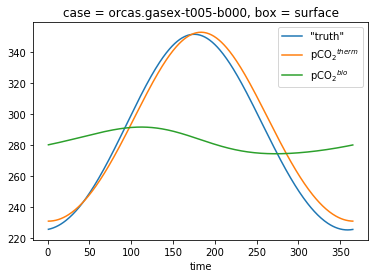

In [40]:
dst.pCO2.plot(label='"truth"')
pco2_T.plot(label='pCO$_2$$^{therm}$')
(dst.pCO2-pco2_T+dst.pCO2.mean()).plot(label='pCO$_2$$^{bio}$')

plt.legend()

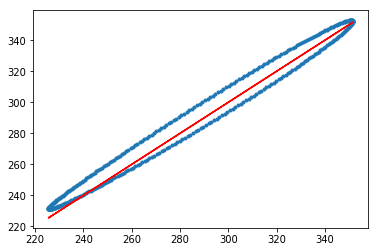

In [41]:
plt.plot(dst.pCO2, pco2_T, '.')
plt.plot(dst.pCO2, dst.pCO2, 'r-')

### Second approach

$p\mathrm{CO}_{2, n+1}^{therm}  = p\mathrm{CO}_{2, n} \cdot \mathrm{exp}(T_{n+1} - T_{n})$

In [49]:
dT = ds.TEMP.roll(time=1) - ds.TEMP
pCO2_T = dst.pCO2.roll(time=1) * np.exp(dT)

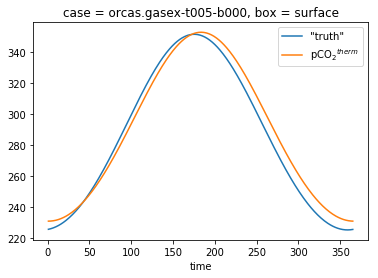

In [50]:
dst.pCO2.plot(label='"truth"')
pco2_T.plot(label='pCO$_2$$^{therm}$')
plt.legend()